In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

In [2]:
data_path = Path.cwd().parent.joinpath("train_data_fix_concat.csv")

In [3]:
data = pd.read_csv(data_path.__str__())
data = data.drop_duplicates()
data = data[data['oil_property_param_value'].notna()]

### Тип масла - Масло - свойство - компоненты - свойства компонентов

In [8]:
# Все возможные масла
total_oil_ids = data["blend_id"].drop_duplicates().to_list()
print(f"Total oil ids -- {len(total_oil_ids)}")

# Все используемые компоненты
total_components = list(set(data["component_name"].to_list()))
print(f"Total chemical components -- {len(total_components)}")

# Все возможные свойства компонентов
total_component_properties = list(set(data["component_property_param_title"]))
print(f"Total chemical components properties -- {len(total_component_properties)}")

# Все возможные расширения для компонентов
total_component_classes = list(set(data["component_class"]))
print(f"Total chemical components classes -- {len(total_component_classes)}")



print(f"X vector length -- {len(total_components) * len(total_component_properties)} + N of oil addons")

Total oil ids -- 348
Total chemical components -- 112
Total chemical components properties -- 63
Total chemical components classes -- 14
X vector length -- 7056 + N of oil addons


In [9]:
# Фиксируем только свойство по ТЗ
workdata = data
workdata_oil_ids = list(set(workdata["blend_id"].to_list()))

### Создаем шаблон вектора X

In [10]:
vector_template = np.zeros(len(total_components) * len(total_component_properties))

def convertDataToVector(components, components_propeties_names, components_propetries_values):
    result_vector = np.zeros(len(total_components) * len(total_component_properties))
    result_vector = np.array([np.float64(-1.0) for x in result_vector])
    
    for component_index, component_name in enumerate(components):
        
        # Индекс в векторе конкретного компонента
        component_vector_index = total_components.index(component_name)
        
        for component_property_index, component_propetry in enumerate(components_propeties_names[component_index]):

            # Индекс в векторе конкретного свойства компонента
            property_vector_index = total_component_properties.index(component_propetry)

            inserting_index = int((component_vector_index *  len(total_component_properties)) + property_vector_index)
            result_vector[inserting_index] = components_propetries_values[component_index][component_property_index]
            
    return result_vector

### 1) Кодируем масло в вектор компонент

In [11]:
Y_data = []
X_data = []

In [12]:
current_id = workdata_oil_ids[1]

for index in range(len(workdata_oil_ids)):
    current_id = workdata_oil_ids[index]
    current_oil_data = workdata.loc[workdata["blend_id"] == current_id]
    
    components_in_oil = list(set(current_oil_data["component_name"].to_list()))
    
    components_propetries_to_function = []
    components_values_to_function = []
    
    for component in components_in_oil:
        # Извлекаю данные
        current_component_oil_data = current_oil_data.loc[current_oil_data["component_name"] == component]
        components_addons_class = list(set(current_component_oil_data["component_class"].to_list()))
        components_addons_polymer = list(set(current_component_oil_data["polymer"].to_list()))
        components_properties = current_component_oil_data["component_property_param_title"].to_list()
    
        # Подготавливаю для вектора
        current_component_properties = []
        current_component_values = []
    
        # Забираю значения по свойствам
        for component_property in components_properties:
            current_property_component_oil_data = current_component_oil_data.loc[current_component_oil_data["component_property_param_title"] == component_property]
            value = current_property_component_oil_data["component_property_param_value"].fillna(0.0).values[0]
            
            current_component_properties.append(component_property)
            current_component_values.append(value)
    
        # Добавляю по свойствам для функции векторизации
        components_values_to_function.append(current_component_values)
        components_propetries_to_function.append(current_component_properties)

    current_result_vector = convertDataToVector(components_in_oil, components_propetries_to_function, components_values_to_function)

    X_data.append(current_result_vector)
    Y_data.append(list(set(current_oil_data["oil_property_param_value"].to_list()))[0])

### 2) Формируем набор данных для обучения

In [13]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

x_train, x_test, y_train, y_test = train_test_split(np.array(X_data), np.array(Y_data), test_size=0.1)

In [14]:
x_test

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1.,  0., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1.,  0., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

### 3) Обучаем разные модели, смотрим по МАЕ какая лучше

### Keras 6d50

In [5]:
import tensorflow as tf 
import os
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Input

layer_length = np.shape(x_train[0])

NameError: name 'x_train' is not defined

In [32]:
model = Sequential()
model.add(Input(shape=layer_length))
model.add(Dense(4096, activation='sigmoid'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2048, activation='sigmoid'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='linear'))
model.add(Dense(1024, activation='linear'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss="mae", metrics=[keras.metrics.mean_absolute_error])

In [33]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="8d8182_300_50/checkpoint.model.keras",
    monitor='mae',
    mode='auto',
    save_best_only=True)

In [34]:
# fit the model to the data
model.fit(np.array(x_train), np.array(y_train), epochs=50, verbose=1, steps_per_epoch=50, batch_size=5, callbacks=[model_checkpoint_callback])

Epoch 1/50
33/50 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - loss: 14564.9902 - mean_absolute_error: 14564.9902

KeyboardInterrupt: 

### Torch 

In [32]:
import time

import torch
import torch.cuda
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(x_train)

shape = np.shape(x_train[0])[0]
num_rows = len(x_train)

model = nn.Sequential(
    nn.Linear(shape, out_features=4096),
    nn.Sigmoid(),
    nn.Linear(4096,1024),
    nn.ReLU(),
    nn.Linear(1024,1)
).to(device)
opt = optim.SGD(model.parameters(), lr=0.01)
loss_func = F.mse_loss
epochs = 100
batch_size = 5

start_time = time.time()
for epoch in range(epochs):
    print(loss)
    for i in range((num_rows-1)//batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step() # Updating weights.
        opt.zero_grad()

print("Time to train linear model with basics:", round(time.time() - start_time),"seconds." ,"epochs:", epochs)

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce GTX 970
Using cuda device
tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])
starting 


C:\Users\Undefined\AppData\Local\Temp\ipykernel_20808\1618011431.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
C:\Users\Undefined\AppData\Local\Temp\ipykernel_20808\1618011431.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
C:\Users\Undefined\AppData\Local\Temp\ipykernel_20808\1618011431.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
C:\Users\Undefined\AppData\Local\

starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
starting 
Time to tr

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE --- 18742.87001613829
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

C:\Users\Undefined\AppData\Local\Temp\ipykernel_1028\3355050586.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\Undefined\AppData\Local\Temp\ipykernel_1028\3355050586.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


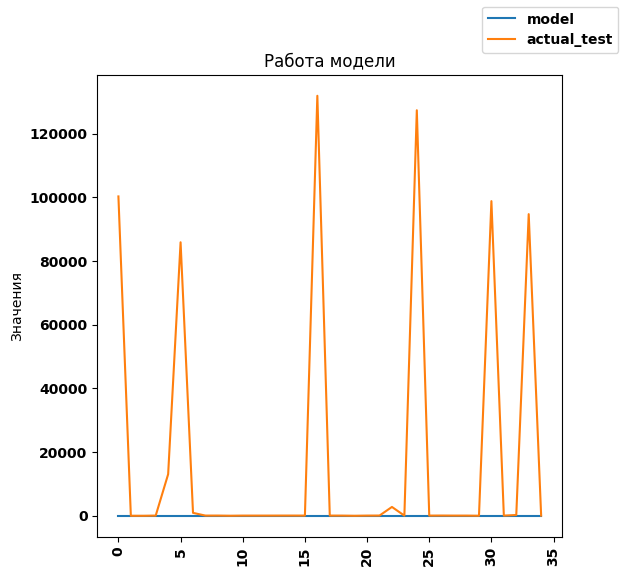

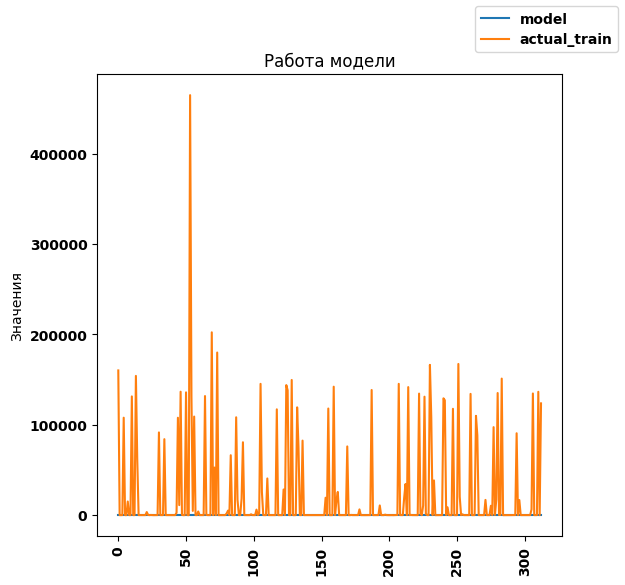

In [27]:
from sklearn.metrics import mean_absolute_error

predictions = model.predict(x_test)
predictions = np.array([x[0] for x in predictions])

mae = mean_absolute_error(y_test, predictions)
print(f"MAE --- {mae}")

import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)

plt.rcParams['figure.figsize'] = [6, 6]

fig, ax = plt.subplots()
ax.plot(range(len(predictions)), predictions, label="model")
ax.plot(range(len(y_test)), y_test, label="actual_test")
ax.set(ylabel='Значения', title='Работа модели')
plt.xticks(rotation = 90)
fig.legend()
fig.show()


fig, ax = plt.subplots()

predictions = model.predict(x_train)
predictions = np.array([x[0] for x in predictions])

ax.plot(range(len(predictions)), predictions, label="model")
ax.plot(range(len(y_train)), y_train, label="actual_train")
ax.set(ylabel='Значения', title='Работа модели')
plt.xticks(rotation = 90)
fig.legend()
fig.show()

In [25]:
model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505],
       [4.8304505]], dtype=float32)

### 4) Сравнение алгоритмов

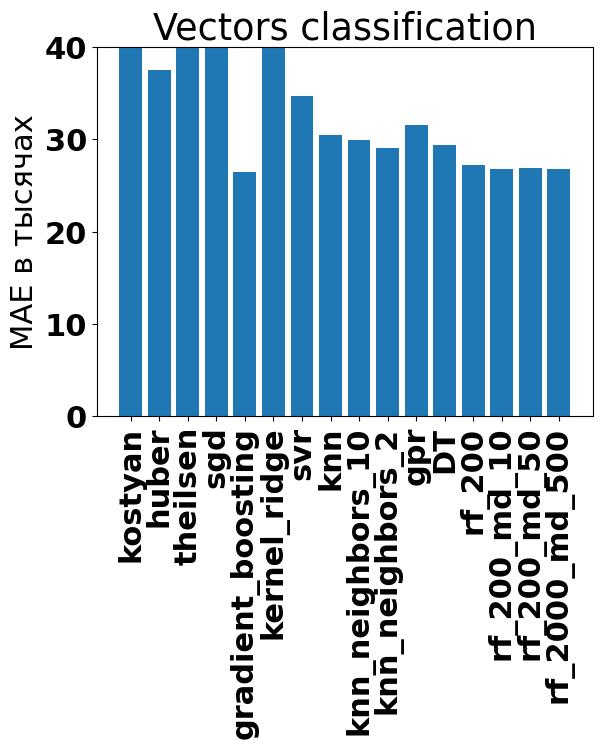

In [37]:
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

fig, ax = plt.subplots()
bar_container = ax.bar(names, [x / 1000 for x in mae_values])
ax.set(ylabel='MAE в тысячах', title='Vectors classification', ylim=(0, 40))
plt.rcParams['figure.figsize'] = [20, 20]
plt.xticks(rotation = 90)

fig.savefig("graph.png")

### 5) Предсказываем на сабмит

In [332]:
path_to_test_data = Path().cwd().parent.joinpath("test_set_public.csv")

test_df = pd.read_csv(path_to_test_data.__str__())
test_df

,oil_type,blend_id,oil_property_param_title,oil_property_param_value,component_name,component_type_title,component_property_param_title,component_property_param_value
0,c25411c1-0bec-41f3-8eee-81daaed2b890,d272c9a6-3332-11ed-9685-005056921581,7c8a81df-b7e7-4507-aab1-79a61fce7887,4.94,b26322a8-b4fa-41cc-a755-757b41d22919,6063ef2b-3eb8-4bf9-a473-0e3d3042fde7,5cf8e492-dfea-4ecb-8799-a97989c46256,0.0000
1,c25411c1-0bec-41f3-8eee-81daaed2b890,d272c9a6-3332-11ed-9685-005056921581,7c8a81df-b7e7-4507-aab1-79a61fce7887,4.94,b26322a8-b4fa-41cc-a755-757b41d22919,6063ef2b-3eb8-4bf9-a473-0e3d3042fde7,9e2de643-ddca-487e-b9e7-69b25d8662bf,0.0000
2,c25411c1-0bec-41f3-8eee-81daaed2b890,d272c9a6-3332-11ed-9685-005056921581,7c8a81df-b7e7-4507-aab1-79a61fce7887,4.94,b26322a8-b4fa-41cc-a755-757b41d22919,6063ef2b-3eb8-4bf9-a473-0e3d3042fde7,f6cc205c-a44d-40e5-9462-2eab4a673e2a,0.0001
3,c25411c1-0bec-41f3-8eee-81daaed2b890,d272c9a6-3332-11ed-9685-005056921581,7c8a81df-b7e7-4507-aab1-79a61fce7887,4.94,b26322a8-b4fa-41cc-a755-757b41d22919,6063ef2b-3eb8-4bf9-a473-0e3d3042fde7,d6eff30f-788e-48a2-b2bd-cbba188f4e63,0.0006
4,c25411c1-0bec-41f3-8eee-81daaed2b890,d272c9a6-3332-11ed-9685-005056921581,7c8a81df-b7e7-4507-aab1-79a61fce7887,4.94,b26322a8-b4fa-41cc-a755-757b41d22919,6063ef2b-3eb8-4bf9-a473-0e3d3042fde7,049e5cb9-9c20-438c-9ef2-96870712a0be,0.0001
...,...,...,...,...,...,...,...,...
110118,c25411c1-0bec-41f3-8eee-81daaed2b890,97249b7a-9590-11ed-84b7-005056921581,9fa62975-847a-469e-bd3e-e0e133141ab0,1800.00,abf252e5-fe01-4700-847e-fb782e22b50c,fa496c3a-927c-4aee-987a-c84b41ceec11,908bf166-393a-4e90-93d8-5d7b9944d637,0.0000
110119,c25411c1-0bec-41f3-8eee-81daaed2b890,97249b7a-9590-11ed-84b7-005056921581,9fa62975-847a-469e-bd3e-e0e133141ab0,1800.00,abf252e5-fe01-4700-847e-fb782e22b50c,fa496c3a-927c-4aee-987a-c84b41ceec11,d12a35d5-14a3-4828-9c59-bff8e912034d,40.0000
110120,c25411c1-0bec-41f3-8eee-81daaed2b890,97249b7a-9590-11ed-84b7-005056921581,9fa62975-847a-469e-bd3e-e0e133141ab0,1800.00,abf252e5-fe01-4700-847e-fb782e22b50c,fa496c3a-927c-4aee-987a-c84b41ceec11,08db8d40-6b81-44ab-ab91-4b482ebc4187,40.0000
110121,c25411c1-0bec-41f3-8eee-81daaed2b890,97249b7a-9590-11ed-84b7-005056921581,9fa62975-847a-469e-bd3e-e0e133141ab0,1800.00,abf252e5-fe01-4700-847e-fb782e22b50c,fa496c3a-927c-4aee-987a-c84b41ceec11,e3983d82-8773-4e46-8f88-147098d7b87a,15.6000


In [206]:
X_test_vector = []
Ids = []

In [207]:
workdata = test_df.drop_duplicates()
workdata_oil_ids = workdata["blend_id"].drop_duplicates().to_list()
workdata_oil_ids

['d272c9a6-3332-11ed-9685-005056921581',
 'dea007ac-a065-11ed-9f24-005056921581',
 '14efbc8a-9090-11ec-83a1-005056921581',
 'e48772c8-4e07-11ed-9a6d-005056921581',
 '72b7aafa-d791-11ed-8145-005056921581',
 'cf7e06d0-bc99-11ec-9ebf-005056921581',
 'c4af79fc-5a8f-11ed-96db-005056921581',
 '53692f3c-8841-11ee-9dd6-005056921581',
 'bece165e-53fd-11ec-92cf-005056921581',
 'b617ecdc-c4a6-11ec-9ebf-005056921581',
 '4d436672-7ae6-11ed-9727-005056921581',
 '39ec78c0-637a-11ee-92b6-005056921581',
 '03ac1c22-6af9-11ed-8d22-005056921581',
 'ed0f4c7e-9590-11ed-84b7-005056921581',
 'b5e28684-a9dd-11ec-9d4e-005056921581',
 '3545c644-5441-11ed-993d-005056921581',
 'f1f40fea-2eac-11ed-8c6c-005056921581',
 '7441fe6e-4c48-11ec-8a77-005056921581',
 'ad063bfc-e4c7-11ed-9764-005056921581',
 '96f82750-0f31-11ee-9c71-005056921581',
 'e25e1804-6977-11ed-85f4-005056921581',
 'c16c5606-028e-11ed-9242-005056921581',
 '426bca34-828c-11ed-9fa7-005056921581',
 '8394d01c-5e3b-11ec-803b-005056921581',
 'dbfc8918-e272-

In [208]:
vector_template = np.zeros(len(total_components) * len(total_component_properties))

missing_components = []
missing_properties = []
def convertDataToVectorTest(components, components_propeties_names, components_propetries_values):
    result_vector = np.zeros(len(total_components) * len(total_component_properties))
    result_vector = np.array([np.float64(-9999999.0) for x in result_vector])
    
    for component_index, component_name in enumerate(components):

        try:
            # Индекс в векторе конкретного компонента
            component_vector_index = total_components.index(component_name)
        except:
            print(f"Component {component_name} not in TRAIN DATA!")
            missing_components.append(component_name)
        
        for component_property_index, component_propetry in enumerate(components_propeties_names[component_index]):
            try:
                # Индекс в векторе конкретного свойства компонента
                property_vector_index = total_component_properties.index(component_propetry)
            
                inserting_index = int((component_vector_index *  len(total_component_properties)) + property_vector_index)
                result_vector[inserting_index] = components_propetries_values[component_index][component_property_index]

            except: 
                print(f"Property {component_property} is missing in TRAIN DATA!")
                missing_properties.append(component_propetry)
            
            
    return result_vector

In [209]:

for index in range(len(workdata_oil_ids)):
    current_id = workdata_oil_ids[index]
    current_oil_data = workdata.loc[workdata["blend_id"] == current_id]
    
    components_in_oil = list(set(current_oil_data["component_name"].to_list()))
    
    components_propetries_to_function = []
    components_values_to_function = []
    
    for component in components_in_oil:
        # Извлекаю данные
        current_component_oil_data = current_oil_data.loc[current_oil_data["component_name"] == component]
        components_properties = current_component_oil_data["component_property_param_title"].to_list()
    
        # Подготавливаю для вектора
        current_component_properties = []
        current_component_values = []
    
        # Забираю значения по свойствам
        for component_property in components_properties:
            current_property_component_oil_data = current_component_oil_data.loc[current_component_oil_data["component_property_param_title"] == component_property]
            value = current_property_component_oil_data["component_property_param_value"].fillna(-9999999.0).values[0]
            
            current_component_properties.append(component_property)
            current_component_values.append(value)
    
        # Добавляю по свойствам для функции векторизации
        components_values_to_function.append(current_component_values)
        components_propetries_to_function.append(current_component_properties)

    current_result_vector = convertDataToVectorTest(components_in_oil, components_propetries_to_function, components_values_to_function)

    X_test_vector.append(current_result_vector)
    Ids.append(current_id)

Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAI

In [210]:
list(set(missing_components))

['GA5251',
 'К-433',
 'KUSAPOUR 85',
 'ЯНОС VHVI-6',
 'Компонент масла 3 погон',
 'PAO-6 EM',
 'Syntolux V15',
 'Evooil ITD-LG 2200 (Lubrizol 8405A)',
 'PX VI219 (Viscoplex 8-219)',
 'ATF WS',
 'Kusacryl 21618',
 'Transfer LF 75W',
 'BT 1#',
 'PAO 100 (PetroChina)',
 'ПМА - 7/Д']

In [211]:
list(set(missing_properties))

['- CP',
 'f6cc205c-a44d-40e5-9462-2eab4a673e2a',
 '- CN',
 '94d89046-80c9-41a8-9d0c-d587d9ed18c2',
 'd037c9ef-a6e1-4328-832a-9db50bbb92af',
 '943ccc3a-58c3-4ef7-a41f-02aa4956aeb1',
 'd6eff30f-788e-48a2-b2bd-cbba188f4e63',
 '24acf244-3846-49a7-be19-ebbff58fde91',
 '2bf4e562-53bd-4e6f-9f83-c30a892170e1',
 'П-ль преломления',
 '085c81d0-1885-4560-a4d3-08f9c0d108e2',
 '928fc6d7-374c-45c9-99bd-39de63a3f140',
 '00f815e2-e93a-4bac-9e2b-9733d77ab1ea',
 'b38cd6d1-cc71-4771-9d9c-7b37ae274fe9',
 '76287f81-2806-481a-8dc6-7274a761e2f9',
 '161776ad-2131-4557-a1f2-995bacb90bf0',
 '59a51599-1085-4a3e-9623-0a819b722db3',
 '52178b55-5b8f-48c4-8e8c-021f1facf40a',
 'a8bc9c11-42cb-4452-8cc8-8f96eb3d7705',
 '7fa1099c-cc3d-4bc2-ab0b-daa4fce8002e',
 '7fde038e-937b-4420-a4de-daf51b2ab54a',
 '50d7e65f-df1c-4e73-8961-9608846cf1d3',
 '834c8f63-4212-4e7e-b28e-2c79a42eb52f',
 '049e5cb9-9c20-438c-9ef2-96870712a0be',
 '- CA',
 'ebe9475f-b29f-4ffd-86af-a16a8321f1ee',
 '53d6b944-dbbd-40ee-a5b3-89bd0c983ab9',
 'Анилин.

In [212]:
len(list(set(missing_components)))

15

In [213]:
len(list(set(missing_properties)))

31

In [214]:
len(Ids)

138

In [215]:
best_predict = rf_2000_md_500.predict(X_test_vector)

In [216]:
submit = pd.DataFrame(Ids, columns=["blend_id"])

In [217]:
submit["result"] = best_predict

In [218]:
submit.to_csv("5th_rf2000.csv", encoding="utf-8", index=False)

In [219]:
submit

,blend_id,result
0,d272c9a6-3332-11ed-9685-005056921581,16148.403941
1,dea007ac-a065-11ed-9f24-005056921581,10007.697151
2,14efbc8a-9090-11ec-83a1-005056921581,10423.886262
3,e48772c8-4e07-11ed-9a6d-005056921581,15659.046993
4,72b7aafa-d791-11ed-8145-005056921581,10324.304214
...,...,...
133,994a200e-853c-11ee-9d2f-005056921581,11253.860864
134,eb25ecae-7886-11ee-9d5b-005056921581,18556.186402
135,e63f290a-fe22-11ed-8421-005056921581,17337.683973
136,f7ff118c-eb17-11ed-9974-005056921581,15845.069432
